# Welcome to Tutorial 3!


---

####  **This tutorial shall explore Disease models in [Episimmer](https://github.com/healthbadge/episimmer/tree/master).**



##### Let us perform some initialization first. 

In [3]:
!pip3 install episimmer --no-dependencies
!git clone https://github.com/healthbadge/episimmer.git
%cd episimmer
from google.colab.patches import cv2, cv2_imshow
from google.colab import _message

     |████████████████████████████████| 64 kB 1.7 MB/s 
     |████████████████████████████████| 10.3 MB 9.2 MB/s 
     |████████████████████████████████| 15.7 MB 41.0 MB/s 
     |████████████████████████████████| 1.9 MB 48.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
     |████████████████████████████████| 4.3 MB 57.7 MB/s 
     |████████████████████████████████| 247 kB 74.1 MB/s 
     |████████████████████████████████| 98 kB 6.6 MB/s 
     |████████████████████████████████| 1.1 MB 46.4 MB/s 
     |████████████████████████████████| 132 kB 41.2 MB/s 
     |████████████████████████████████| 793 kB 69.3 MB/s 
     |████████████████████████████████| 59 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 53.0 MB/s 
     |████████████████████████████████| 1.6 MB 45.9 MB/s 
     |████████████████████████████████| 381 kB 59.1 MB/s 
     |████████████████████████████████| 102 kB 10.4 MB/s 
     |████████████████████████████████| 100 kB 8.4 MB/s 


Cloning into 'episimmer'...
remote: Enumerating objects: 6497, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 6497 (delta 37), reused 41 (delta 16), pack-reused 6424
Receiving objects: 100% (6497/6497), 49.40 MiB | 33.39 MiB/s, done.
Resolving deltas: 100% (4406/4406), done.
/content/episimmer
     |████████████████████████████████| 131 kB 5.0 MB/s 
     |████████████████████████████████| 130 kB 41.4 MB/s 
     |████████████████████████████████| 428 kB 46.0 MB/s 
     |████████████████████████████████| 40 kB 5.5 MB/s 
     |████████████████████████████████| 280 kB 66.8 MB/s 
     |████████████████████████████████| 1.8 MB 63.4 MB/s 
     |████████████████████████████████| 87 kB 6.0 MB/s 
     |████████████████████████████████| 1.1 MB 54.8 MB/s 


# Disease Model

---

### *To recap*


Disease models are used to model the spread of disease across agents in the environment. Agents are the disease carriers and all the different types of interactions present facilitate the spread of infection.

In Episimmer, There are two basic types of disease models -

1. *Stochastic Model* 

2. *Scheduled Model*

Both follow the [compartmental style of disease modelling](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) i.e. they have compartments or states that define the agent's disease state. They only differ by how they transition. Stochastic model allows us to implement compartmental models with probabilistic changes in state. For example, an infected agent can recover with a probability of 0.2. Scheduled models have transitions that are scheduled based on a distribution. For example in the real world an infected person might take on average 10 days with a variance of 2 days to recover i.e. $\mathcal{N}(\mu,\,\sigma^{2})$ where $\mu = 10$ and $\sigma^{2} = 2$.

Both of these models must be implemented by the user using the UserModel.py file. Note that this file is a mandatory file required for any simulation in Episimmer.
An example file is shown below (from example Stochastic_SIR) -

```python
import episimmer.model as model

#The two functions event_contribute_fn and event_receive_fn together control the spread of infection

# This function states the amount an agent contributes to ambient infection in the region
#note that only infected agents contibute to the ambient infection
def event_contribute_fn(agent,event_info,location,current_time_step):
	if agent.state=='Infected':
		return 1
	return 0

#This function states the probability of an agent becoming infected from the ambient infection
def event_receive_fn(agent,ambient_infection,event_info,location,current_time_step):
	beta=0.001
	return ambient_infection*beta


class UserModel(model.StochasticModel):
	def __init__(self):
		individual_types=['Susceptible','Infected','Recovered']	#These are the states that will be used by the compartmental model
		infected_states=['Infected']	#These are the states that can infect
		state_proportion={				#This is the starting proportions of each state
							'Susceptible':0.99,
							'Infected':0.01,
							'Recovered':0
						}
		model.StochasticModel.__init__(self,individual_types,infected_states,state_proportion)  #We use the inbuilt model in the package
		self.set_transition('Susceptible', 'Infected', self.p_infection())	#Adding S-> I dependent transition
		self.set_transition('Infected', 'Recovered', self.p_standard(0.2))	#Adding the I->R transition


		self.set_event_contribution_fn(event_contribute_fn)	#Setting the above defined function into the model
		self.set_event_receive_fn(event_receive_fn)	#Setting the above defined function into the model

		self.name='Stochastic SIR'
```




---

The following concepts show you basic concepts of disease modelling in Episimmer. 

### Stochastic Model

Stochastic models are defined by defining a class inheriting the model.StochasticModel class. You must pass the individual types, infected states and state proportions to the parent's init function. Thus, we first define the state parameters.

```
model.StochasticModel.__init__(self,individual_types,infected_states,state_proportion)
```

Then, we define the transitions using the function set_transition which takes three parameters - 

```
set_transition(from_state, to_state, transition_fn)
```

The basic transition functions available are
* p_standard : Takes and returns a fixed probability of transition.
* p_infection : Returns a probability of transition based on all the underlying interactions. No need to pass any parameters as we do not have to worry about Individual or Probabilistic Interactions for now.

```
self.set_transition('Susceptible', 'Infected', self.p_infection())
self.set_transition('Infected', 'Recovered', self.p_standard(0.2))
```


### Scheduled Model


Scheduled models must inherit the model.ScheduledModel class.
Scheduled models work a little differently. We pass almost all parameters including the proportions in the insert_state function.

```
insert_state(state, mean, vary, transition_fn, infected_state, proportion)

state : State name 
mean, vary : Parameters of normal distributions defining number of days to remain in state
transition_fn : Transition from current state to next state 
infected_state : Boolean representing whether the state is an infectious state.
proportion : Initial proportion
```

The basic transition functions available are 
* scheduled : Takes a dictionary with the keys as the next states and the values as the probability of transitioning to that state. Returns a state and scheduled time based on mean and variance passed to the insert_state function. 
* p_infection : Takes a similar dictionary as scheduled function and the same parameters as the Stochastic version of p_infection. Returns a state and scheduled time based on mean and variance passed to the insert_state function and also depends on the underlying interactions.

Common components of both model :
* p_infection performs very similar operations, only the definition of Scheduled models contains the next states as we define the transition in the insert_state function.
* The p_infection function takes parameters to handle interactions of type Individual interactions and probabilistic interactions. What about events and one-time events? They are handled by two functions set_event_contribution_fn and set_event_receive_fn. Both these functions take a callable as parameter which defines the contribution to ambient infection and the probability of being affected by the ambient infection respectively. 


```
self.set_event_contribution_fn(event_contribute_fn)
self.set_event_receive_fn(event_receive_fn)
```
---

You will notice that the cell that defines the model is actually the contents of the UserModel.py file. We will be creating a file with the content of the cell so it is easy to make changes on colab.

In [4]:
# Copy contents from example to current directory for easy google colab use.
!cp -a examples/Basic_Disease_Models/Stochastic_SIR/. .
# read_file('UserModel.py')

In [5]:
# Some helper functions
def read_file(file_name):
  with open(file_name) as f:
    print(f.read())

# Reads the contents of the colab notebook cell. You may also upload your files (particularly UserModel.py). 
def get_model_str(start_string):
  notebook_json_string = _message.blocking_request('get_ipynb', request='', timeout_sec=100)
  for cell in notebook_json_string['ipynb']['cells']:
    if cell['source'][0][:len(start_string)] == start_string:
      return ''.join(cell['source'])
  
  print("Could not find the cell with UserModel.py! Make sure the cell starts with the string you pass at the top of the cell.")


### 1. Changing initial proportions of the compartmental states.

#### Stochastic Model

You can make changes to the initial proportions by changing the values in line 19-21. Just ensure that the proportions add up to 1. 

In [6]:
# Example 1 - Stochastic
import episimmer.model as model

def event_contribute_fn(agent,event_info,location,current_time_step):
	if agent.state=='Infected':
		return 1
	return 0

def event_receive_fn(agent,ambient_infection,event_info,location,current_time_step):
	beta=0.001
	return ambient_infection*beta


class UserModel(model.StochasticModel):
	def __init__(self):
		individual_types=['Susceptible','Infected','Recovered']
		infected_states=['Infected']
		state_proportion={
							'Susceptible':0.99,
							'Infected':0.01,
							'Recovered':0
						}
		# state_proportion={
		# 					'Susceptible':0.75,
		# 					'Infected':0.25,
		# 					'Recovered':0
		# 				}
		model.StochasticModel.__init__(self,individual_types,infected_states,state_proportion)
		self.set_transition('Susceptible', 'Infected', self.p_infection())
		self.set_transition('Infected', 'Recovered', self.p_standard(0.2))


		self.set_event_contribution_fn(event_contribute_fn)
		self.set_event_receive_fn(event_receive_fn)

		self.name='Stochastic SIR'


#### Scheduled Model


You can make changes to the initial proportions by changing the last parameter in lines 18-20. Just ensure that the proportions add up to 1. 

In [7]:
# Example 1 - Scheduled
import episimmer.model as model

def event_contribute_fn(agent,event_info,location,current_time_step):
	if agent.state=='Infected':
		return 1
	return 0

def event_receive_fn(agent,ambient_infection,event_info,location,current_time_step):
	#Example 1
	beta=0.001
	return ambient_infection*beta


class UserModel(model.ScheduledModel):
	def __init__(self):
		model.ScheduledModel.__init__(self)
		self.insert_state('Susceptible',None, None,self.p_infection({'Infected':1}),False,0.99)
		self.insert_state('Infected',6,3,self.scheduled({'Recovered':1}),True,0.01)
		self.insert_state('Recovered',0, 0,self.scheduled({'Recovered':1}),False,0)
	
		# self.insert_state('Susceptible',None, None,self.p_infection({'Infected':1}),False,0.75)
		# self.insert_state('Infected',6,3,self.scheduled({'Recovered':1}),True,0.25)
		# self.insert_state('Recovered',0, 0,self.scheduled({'Recovered':1}),False,0)

		self.set_event_contribution_fn(event_contribute_fn)
		self.set_event_receive_fn(event_receive_fn)


#### Running

We have written a function 'get_model_str' which actually scans through the notebook and finds the cell with the matching header. So be sure to not make changes to the header of the cell containing the model definition. 

In [8]:
user_model_str = get_model_str("# Example 1 - Stochastic")
# user_model_str = get_model_str("# Example 1 - Scheduled") # Uncomment this line to use the Scheduled model

with open("UserModel.py", "w") as f:
  f.write(user_model_str)

# read_file('UserModel.py')

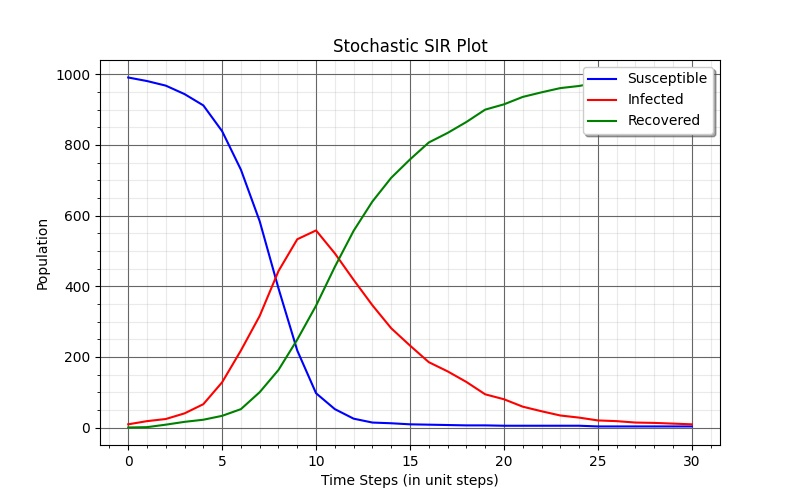

In [9]:
!python3 episimmer/main.py . -np
cv2_imshow(cv2.imread("results/results.jpg"))

### 2. Changing rate of recovery.


#### Stochastic Model

To change rate of recovery one will have to change the value at line 25 when defining the I->R transition.

We increase the rate of recovery from 0.2 to 0.4. Try out both! You will notice the latter case has a shorter peak.

In [10]:
# Example 2 - Stochastic
import episimmer.model as model

def event_contribute_fn(agent,event_info,location,current_time_step):
	if agent.state=='Infected':
		return 1
	return 0

def event_receive_fn(agent,ambient_infection,event_info,location,current_time_step):
	beta=0.001
	return ambient_infection*beta


class UserModel(model.StochasticModel):
	def __init__(self):
		individual_types=['Susceptible','Infected','Recovered']
		infected_states=['Infected']
		state_proportion={
							'Susceptible':0.99,
							'Infected':0.01,
							'Recovered':0
						}
		model.StochasticModel.__init__(self,individual_types,infected_states,state_proportion)
		self.set_transition('Susceptible', 'Infected', self.p_infection())
		self.set_transition('Infected', 'Recovered', self.p_standard(0.2))
		# self.set_transition('Infected', 'Recovered', self.p_standard(0.4))


		self.set_event_contribution_fn(event_contribute_fn)
		self.set_event_receive_fn(event_receive_fn)

		self.name='Stochastic SIR'


#### Scheduled Model

To change rate of recovery, we shall change the number of days spent in the Infected state.

We reduce the number of days by reducing the mean days spent in the Infected state. We can also reduce the variance. Try out both!

In [11]:
# Example 2 - Scheduled
import episimmer.model as model

def event_contribute_fn(agent,event_info,location,current_time_step):
	if agent.state=='Infected':
		return 1
	return 0

def event_receive_fn(agent,ambient_infection,event_info,location,current_time_step):
	#Example 1
	beta=0.001
	return ambient_infection*beta


class UserModel(model.ScheduledModel):
	def __init__(self):
		model.ScheduledModel.__init__(self)
		self.insert_state('Susceptible',None, None,self.p_infection({'Infected':1}),False,0.99)
		self.insert_state('Infected',6,3,self.scheduled({'Recovered':1}),True,0.01)
    # self.insert_state('Infected',3,1,self.scheduled({'Recovered':1}),True,0.01)
		self.insert_state('Recovered',0, 0,self.scheduled({'Recovered':1}),False,0)

		self.set_event_contribution_fn(event_contribute_fn)
		self.set_event_receive_fn(event_receive_fn)


#### Running

We have written a function 'get_model_str' which actually scans through the notebook and finds the cell with the matching header. So be sure to not make changes to the header of the cell containing the model definition. 

In [12]:
user_model_str = get_model_str("# Example 2 - Stochastic")
# user_model_str = get_model_str("# Example 2 - Scheduled") # Uncomment this line to use the Scheduled model
with open("UserModel.py", "w") as f:
  f.write(user_model_str)

# read_file('UserModel.py')

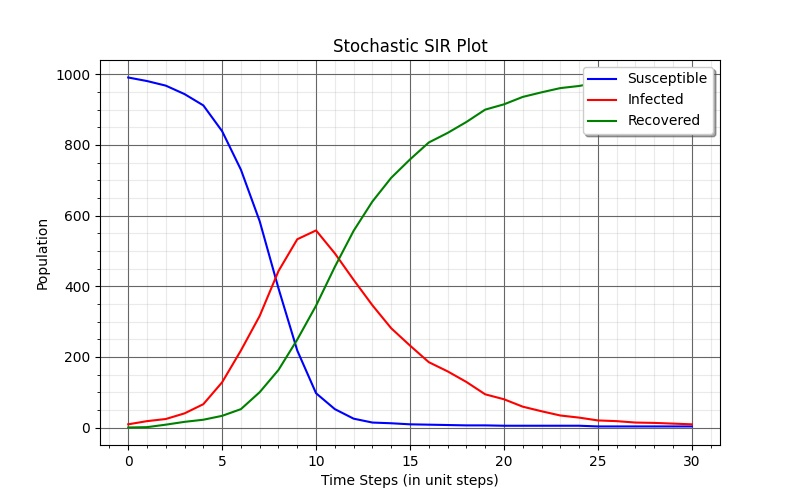

In [13]:
!python3 episimmer/main.py . -np
cv2_imshow(cv2.imread("results/results.jpg"))

### 3. Changing rate of infection.

Recall that events model a complete graph of interactions in two stages :

i) Infectious agents contribute to an ambient infection and then,

ii) Susceptible agents are affected by this ambient infection


Coming back to the problem of changing the rate of infection, for Events, there are two ways to change the rate of infection :
* Increasing each agents contribution to ambient infection 
* Increasing each agents receiving probability from ambient infection

This can be done by changing the values in event_contribute_fn and event_receive_fn.  Considering the SIR model, event_contribute_fn checks every agent in an event and returns a particular value to the ambient_infection based on the agent's state (in this case Infected). event_receive_fn calculates the probability at which an agent can get infected from the ambient_infection (In this case a chance of a susceptible agent becoming infected). 


#### Stochastic Model

In [14]:
# Example 3 - Stochastic
import episimmer.model as model

def event_contribute_fn(agent,event_info,location,current_time_step):
	if agent.state=='Infected':
		return 1
		# return 2
	return 0

def event_receive_fn(agent,ambient_infection,event_info,location,current_time_step):
	beta=0.001
	return ambient_infection*beta


class UserModel(model.StochasticModel):
	def __init__(self):
		individual_types=['Susceptible','Infected','Recovered']
		infected_states=['Infected']
		state_proportion={
							'Susceptible':0.99,
							'Infected':0.01,
							'Recovered':0
						}
		model.StochasticModel.__init__(self,individual_types,infected_states,state_proportion)
		self.set_transition('Susceptible', 'Infected', self.p_infection())
		self.set_transition('Infected', 'Recovered', self.p_standard(0.2))


		self.set_event_contribution_fn(event_contribute_fn)
		self.set_event_receive_fn(event_receive_fn)

		self.name='Stochastic SIR'


#### Scheduled Model 

There is a possibility of using the mean and var parameters for the Susceptible -> Infected state transition but we don't have to as we are using probabilities of transition in this case. But you may choose to use integer values instead of None to further reduce the chance of being infected.

In [15]:
# Example 3 - Scheduled
import episimmer.model as model

def event_contribute_fn(agent,event_info,location,current_time_step):
	if agent.state=='Infected':
		return 1
		# return 2
	return 0

def event_receive_fn(agent,ambient_infection,event_info,location,current_time_step):
	#Example 1
	beta=0.001
	return ambient_infection*beta


class UserModel(model.ScheduledModel):
	def __init__(self):
		model.ScheduledModel.__init__(self)
		self.insert_state('Susceptible',None, None,self.p_infection({'Infected':1}),False,0.99)
		# self.insert_state('Susceptible',2, 1,self.p_infection({'Infected':1}),False,0.99)  
		self.insert_state('Infected',6,3,self.scheduled({'Recovered':1}),True,0.01)
		self.insert_state('Recovered',0, 0,self.scheduled({'Recovered':1}),False,0)

		self.set_event_contribution_fn(event_contribute_fn)
		self.set_event_receive_fn(event_receive_fn)


#### Running

We have written a function 'get_model_str' which actually scans through the notebook and finds the cell with the matching header. So be sure to not make changes to the header of the cell containing the model definition. 

In [16]:
user_model_str = get_model_str("# Example 3 - Stochastic")
# user_model_str = get_model_str("# Example 3 - Scheduled") # Uncomment this line to use the Scheduled model
with open("UserModel.py", "w") as f:
  f.write(user_model_str)

# read_file('UserModel.py')

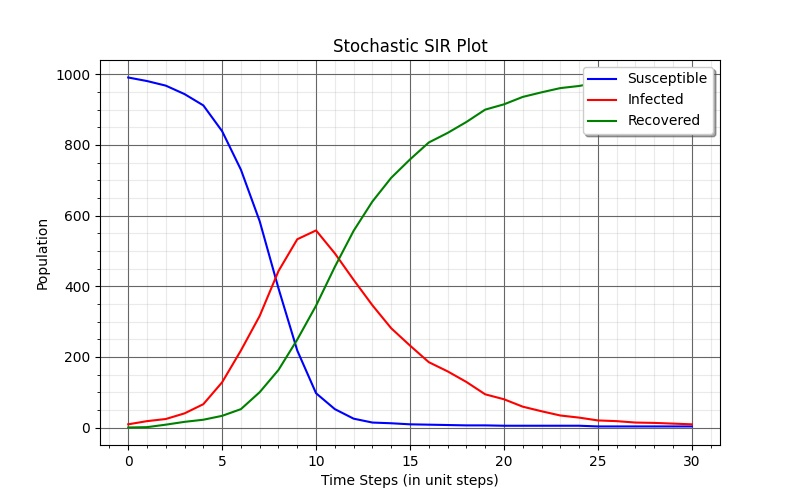

In [17]:
!python3 episimmer/main.py . -np
cv2_imshow(cv2.imread("results/results.jpg"))

### Disclaimer : These colab tutorials are only for reference and they are in no way representative of the entire functionality of Episimmer. Please look at the [Documentation](https://episimmer.readthedocs.io/en/latest/) for more details.